# Use of UNet

In [214]:
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv1d, ReLU, BatchNorm1d, MaxPool1d, Flatten, Linear, Upsample
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
class Conv1D_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Conv1D_Layer, self).__init__()
        self.conv1d = Conv1d(in_channels, out_channels, kernel_size, padding)
        self.relu = Sigmoid()
        self.batchnorm = BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

In [190]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Conv1d(64, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [191]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

In [192]:
df = pd.read_csv(r"Data\Data4.csv")
time = df["0"]
df.drop("0", axis=1, inplace=True)

In [324]:
# Input 
freq1 = 0.75 # Freq1
t01 = 1.4 # Time Shift
t = time
wave = -2*freq1**2*np.pi**2*np.exp(-freq1**2*np.pi**2*(t01 - t)**2)*(t01 - t)*(2*freq1**2*np.pi**2*t01**2 - 4*freq1**2*np.pi**2*t01*t + 2*freq1**2*np.pi**2*t**2 - 3)
# Create acceleration array input
input_acc = wave.values

In [347]:
# Create dataset
X = input_acc.reshape(-1, 1)
Y = df.values

# Create model
args = {"kernel_size": 1, "stride": 1, "padding": 1, "in_channels": 1, "out_channels": 6}
args = objectview(args)

# Convert to tensor
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# Unsqueeze data
X = X.T.unsqueeze(0)
Y = Y.T.unsqueeze(0)
print(X.shape, Y.shape)

torch.Size([1, 1, 1500]) torch.Size([1, 6, 1500])


In [348]:
# Create Dataloader
import torch.utils.data as data

class Dataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

dataset = Dataset(X, Y)

In [349]:
model = UNet(args.in_channels, args.out_channels, args)
pred = model(X)
print(pred.shape, Y.shape, X.shape)
assert pred.shape == Y.shape

torch.Size([1, 6, 1500]) torch.Size([1, 6, 1500]) torch.Size([1, 1, 1500])


In [350]:
from tqdm import trange

# Training function
def train(dataset, model, loss_function, optimizer, scheduler, num_epochs, device):
    model.train()
    losses = []
    for epoch in trange(num_epochs, desc="Training", unit="epoch"):
        for X, Y in dataset:
            X, Y = X.to(device), Y.to(device)
            X, Y = X.unsqueeze(0), Y.unsqueeze(0)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(X)     # Forward pass
            loss = loss_function(outputs, Y)  # Compute loss
            loss.backward()        # Backward pass
            optimizer.step()       # Update weights
            
            losses.append(loss.item())
        
        scheduler.step()  # Update learning rate

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return losses, model

        

In [351]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [352]:
# Start training

model = UNet(args.in_channels, args.out_channels, args).to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))
num_epochs = 10000


In [353]:
losses, model = train(dataset, model, loss_function, optimizer, scheduler, num_epochs, device=device)

Training:   0%|          | 4/10000 [00:00<04:56, 33.67epoch/s]

Epoch 0/10000, Loss: 1.7181593179702759


Training:   1%|▏         | 129/10000 [00:01<01:08, 143.64epoch/s]

Epoch 100/10000, Loss: 1.4703874588012695


Training:   2%|▏         | 219/10000 [00:01<00:57, 170.27epoch/s]

Epoch 200/10000, Loss: 1.4267358779907227


Training:   3%|▎         | 320/10000 [00:02<01:05, 148.51epoch/s]

Epoch 300/10000, Loss: 1.4016189575195312


Training:   4%|▍         | 423/10000 [00:02<00:57, 165.73epoch/s]

Epoch 400/10000, Loss: 1.389167308807373


Training:   5%|▌         | 534/10000 [00:03<00:53, 178.15epoch/s]

Epoch 500/10000, Loss: 1.3622899055480957


Training:   6%|▌         | 624/10000 [00:04<00:53, 174.75epoch/s]

Epoch 600/10000, Loss: 1.3427599668502808


Training:   7%|▋         | 732/10000 [00:04<00:54, 171.26epoch/s]

Epoch 700/10000, Loss: 1.3434381484985352


Training:   8%|▊         | 824/10000 [00:05<00:51, 176.87epoch/s]

Epoch 800/10000, Loss: 1.3095417022705078


Training:   9%|▉         | 932/10000 [00:05<00:52, 172.30epoch/s]

Epoch 900/10000, Loss: 1.291755199432373


Training:  10%|█         | 1025/10000 [00:06<00:49, 180.92epoch/s]

Epoch 1000/10000, Loss: 1.3001430034637451


Training:  11%|█         | 1120/10000 [00:06<00:50, 176.70epoch/s]

Epoch 1100/10000, Loss: 1.2719552516937256


Training:  12%|█▏        | 1230/10000 [00:07<00:50, 175.03epoch/s]

Epoch 1200/10000, Loss: 1.265303611755371


Training:  13%|█▎        | 1321/10000 [00:08<00:50, 173.52epoch/s]

Epoch 1300/10000, Loss: 1.2809460163116455


Training:  14%|█▍        | 1432/10000 [00:08<00:47, 179.94epoch/s]

Epoch 1400/10000, Loss: 1.2758071422576904


Training:  15%|█▌        | 1525/10000 [00:09<00:47, 177.68epoch/s]

Epoch 1500/10000, Loss: 1.2663242816925049


Training:  16%|█▌        | 1616/10000 [00:09<00:47, 175.25epoch/s]

Epoch 1600/10000, Loss: 1.2507455348968506


Training:  17%|█▋        | 1728/10000 [00:10<00:46, 179.25epoch/s]

Epoch 1700/10000, Loss: 1.2473052740097046


Training:  18%|█▊        | 1823/10000 [00:10<00:46, 176.99epoch/s]

Epoch 1800/10000, Loss: 1.2406939268112183


Training:  19%|█▉        | 1932/10000 [00:11<00:45, 176.59epoch/s]

Epoch 1900/10000, Loss: 1.250452995300293


Training:  20%|██        | 2023/10000 [00:11<00:45, 175.58epoch/s]

Epoch 2000/10000, Loss: 1.231757640838623


Training:  21%|██▏       | 2132/10000 [00:12<00:45, 171.65epoch/s]

Epoch 2100/10000, Loss: 1.2204231023788452


Training:  22%|██▏       | 2224/10000 [00:13<00:43, 179.43epoch/s]

Epoch 2200/10000, Loss: 1.2261477708816528


Training:  23%|██▎       | 2318/10000 [00:13<00:41, 183.41epoch/s]

Epoch 2300/10000, Loss: 1.2261288166046143


Training:  24%|██▍       | 2432/10000 [00:14<00:42, 180.15epoch/s]

Epoch 2400/10000, Loss: 1.2361506223678589


Training:  25%|██▌       | 2528/10000 [00:14<00:40, 183.05epoch/s]

Epoch 2500/10000, Loss: 1.2213654518127441


Training:  26%|██▌       | 2624/10000 [00:15<00:39, 184.63epoch/s]

Epoch 2600/10000, Loss: 1.210356593132019


Training:  27%|██▋       | 2739/10000 [00:15<00:39, 185.20epoch/s]

Epoch 2700/10000, Loss: 1.2076634168624878


Training:  28%|██▊       | 2831/10000 [00:16<00:40, 178.66epoch/s]

Epoch 2800/10000, Loss: 1.207592248916626


Training:  29%|██▉       | 2923/10000 [00:16<00:39, 176.94epoch/s]

Epoch 2900/10000, Loss: 1.1986610889434814


Training:  30%|███       | 3033/10000 [00:17<00:40, 172.68epoch/s]

Epoch 3000/10000, Loss: 1.2137507200241089


Training:  31%|███▏      | 3128/10000 [00:18<00:38, 179.05epoch/s]

Epoch 3100/10000, Loss: 1.2123403549194336


Training:  32%|███▏      | 3222/10000 [00:18<00:37, 180.99epoch/s]

Epoch 3200/10000, Loss: 1.2108912467956543


Training:  33%|███▎      | 3318/10000 [00:19<00:36, 182.82epoch/s]

Epoch 3300/10000, Loss: 1.211014747619629


Training:  34%|███▍      | 3432/10000 [00:19<00:37, 173.82epoch/s]

Epoch 3400/10000, Loss: 1.199309229850769


Training:  35%|███▌      | 3517/10000 [00:20<00:41, 158.11epoch/s]

Epoch 3500/10000, Loss: 1.2126967906951904


Training:  36%|███▌      | 3620/10000 [00:21<00:38, 165.59epoch/s]

Epoch 3600/10000, Loss: 1.2010531425476074


Training:  37%|███▋      | 3723/10000 [00:21<00:38, 164.49epoch/s]

Epoch 3700/10000, Loss: 1.1894314289093018


Training:  38%|███▊      | 3829/10000 [00:22<00:39, 158.19epoch/s]

Epoch 3800/10000, Loss: 1.184109091758728


Training:  39%|███▉      | 3925/10000 [00:22<00:41, 148.06epoch/s]

Epoch 3900/10000, Loss: 1.1950323581695557


Training:  40%|████      | 4025/10000 [00:23<00:36, 161.66epoch/s]

Epoch 4000/10000, Loss: 1.189366340637207


Training:  41%|████      | 4112/10000 [00:24<00:37, 157.39epoch/s]

Epoch 4100/10000, Loss: 1.18058443069458


Training:  42%|████▏     | 4225/10000 [00:24<00:37, 155.62epoch/s]

Epoch 4200/10000, Loss: 1.1907904148101807


Training:  43%|████▎     | 4324/10000 [00:25<00:37, 151.67epoch/s]

Epoch 4300/10000, Loss: 1.1923476457595825


Training:  44%|████▍     | 4423/10000 [00:26<00:36, 153.82epoch/s]

Epoch 4400/10000, Loss: 1.1877163648605347


Training:  45%|████▌     | 4521/10000 [00:26<00:35, 153.10epoch/s]

Epoch 4500/10000, Loss: 1.1896597146987915


Training:  46%|████▌     | 4620/10000 [00:27<00:34, 156.96epoch/s]

Epoch 4600/10000, Loss: 1.19595468044281


Training:  47%|████▋     | 4725/10000 [00:28<00:31, 169.12epoch/s]

Epoch 4700/10000, Loss: 1.192157506942749


Training:  48%|████▊     | 4823/10000 [00:28<00:33, 154.88epoch/s]

Epoch 4800/10000, Loss: 1.1880059242248535


Training:  49%|████▉     | 4924/10000 [00:29<00:32, 155.21epoch/s]

Epoch 4900/10000, Loss: 1.2005616426467896


Training:  50%|█████     | 5023/10000 [00:29<00:30, 160.61epoch/s]

Epoch 5000/10000, Loss: 1.1869289875030518


Training:  51%|█████     | 5122/10000 [00:30<00:32, 150.27epoch/s]

Epoch 5100/10000, Loss: 1.190087914466858


Training:  52%|█████▏    | 5217/10000 [00:31<00:33, 144.67epoch/s]

Epoch 5200/10000, Loss: 1.1793334484100342


Training:  53%|█████▎    | 5328/10000 [00:32<00:30, 151.94epoch/s]

Epoch 5300/10000, Loss: 1.1893424987792969


Training:  54%|█████▍    | 5426/10000 [00:32<00:29, 152.96epoch/s]

Epoch 5400/10000, Loss: 1.175758957862854


Training:  55%|█████▌    | 5526/10000 [00:33<00:28, 157.91epoch/s]

Epoch 5500/10000, Loss: 1.1855418682098389


Training:  56%|█████▌    | 5624/10000 [00:33<00:27, 158.16epoch/s]

Epoch 5600/10000, Loss: 1.1786119937896729


Training:  57%|█████▋    | 5729/10000 [00:34<00:27, 153.62epoch/s]

Epoch 5700/10000, Loss: 1.1865599155426025


Training:  58%|█████▊    | 5826/10000 [00:35<00:27, 151.87epoch/s]

Epoch 5800/10000, Loss: 1.1892549991607666


Training:  59%|█████▉    | 5922/10000 [00:35<00:25, 157.88epoch/s]

Epoch 5900/10000, Loss: 1.1904287338256836


Training:  60%|██████    | 6030/10000 [00:36<00:24, 159.25epoch/s]

Epoch 6000/10000, Loss: 1.1997431516647339


Training:  61%|██████    | 6120/10000 [00:37<00:22, 169.79epoch/s]

Epoch 6100/10000, Loss: 1.1755952835083008


Training:  62%|██████▏   | 6220/10000 [00:37<00:24, 154.99epoch/s]

Epoch 6200/10000, Loss: 1.1806539297103882


Training:  63%|██████▎   | 6333/10000 [00:38<00:23, 155.31epoch/s]

Epoch 6300/10000, Loss: 1.1776224374771118


Training:  64%|██████▍   | 6426/10000 [00:38<00:19, 179.15epoch/s]

Epoch 6400/10000, Loss: 1.178240418434143


Training:  65%|██████▌   | 6514/10000 [00:39<00:22, 155.28epoch/s]

Epoch 6500/10000, Loss: 1.1815332174301147


Training:  66%|██████▋   | 6631/10000 [00:40<00:20, 161.99epoch/s]

Epoch 6600/10000, Loss: 1.1872752904891968


Training:  67%|██████▋   | 6740/10000 [00:40<00:18, 175.11epoch/s]

Epoch 6700/10000, Loss: 1.1791248321533203


Training:  68%|██████▊   | 6829/10000 [00:41<00:20, 158.09epoch/s]

Epoch 6800/10000, Loss: 1.1789765357971191


Training:  69%|██████▉   | 6928/10000 [00:42<00:19, 158.76epoch/s]

Epoch 6900/10000, Loss: 1.195650339126587


Training:  70%|███████   | 7019/10000 [00:42<00:18, 164.79epoch/s]

Epoch 7000/10000, Loss: 1.1802895069122314


Training:  71%|███████   | 7122/10000 [00:43<00:18, 155.25epoch/s]

Epoch 7100/10000, Loss: 1.1732628345489502


Training:  72%|███████▏  | 7222/10000 [00:43<00:17, 157.57epoch/s]

Epoch 7200/10000, Loss: 1.1764428615570068


Training:  73%|███████▎  | 7319/10000 [00:44<00:17, 151.62epoch/s]

Epoch 7300/10000, Loss: 1.1777623891830444


Training:  74%|███████▍  | 7417/10000 [00:45<00:16, 152.72epoch/s]

Epoch 7400/10000, Loss: 1.1822919845581055


Training:  75%|███████▌  | 7519/10000 [00:45<00:15, 159.67epoch/s]

Epoch 7500/10000, Loss: 1.1847549676895142


Training:  76%|███████▋  | 7629/10000 [00:46<00:14, 166.77epoch/s]

Epoch 7600/10000, Loss: 1.181885838508606


Training:  77%|███████▋  | 7731/10000 [00:47<00:14, 159.65epoch/s]

Epoch 7700/10000, Loss: 1.173081636428833


Training:  78%|███████▊  | 7820/10000 [00:47<00:13, 164.38epoch/s]

Epoch 7800/10000, Loss: 1.1848732233047485


Training:  79%|███████▉  | 7921/10000 [00:48<00:13, 153.09epoch/s]

Epoch 7900/10000, Loss: 1.1829854249954224


Training:  80%|████████  | 8021/10000 [00:48<00:12, 163.13epoch/s]

Epoch 8000/10000, Loss: 1.1771217584609985


Training:  81%|████████  | 8121/10000 [00:49<00:12, 154.16epoch/s]

Epoch 8100/10000, Loss: 1.183501124382019


Training:  82%|████████▏ | 8233/10000 [00:50<00:09, 179.69epoch/s]

Epoch 8200/10000, Loss: 1.1728776693344116


Training:  83%|████████▎ | 8327/10000 [00:50<00:09, 176.94epoch/s]

Epoch 8300/10000, Loss: 1.190816044807434


Training:  84%|████████▍ | 8437/10000 [00:51<00:08, 175.17epoch/s]

Epoch 8400/10000, Loss: 1.1845099925994873


Training:  85%|████████▌ | 8529/10000 [00:51<00:08, 179.22epoch/s]

Epoch 8500/10000, Loss: 1.1863747835159302


Training:  86%|████████▌ | 8623/10000 [00:52<00:07, 178.37epoch/s]

Epoch 8600/10000, Loss: 1.1804348230361938


Training:  87%|████████▋ | 8716/10000 [00:52<00:07, 175.61epoch/s]

Epoch 8700/10000, Loss: 1.1852185726165771


Training:  88%|████████▊ | 8825/10000 [00:53<00:06, 175.32epoch/s]

Epoch 8800/10000, Loss: 1.1702101230621338


Training:  89%|████████▉ | 8916/10000 [00:54<00:06, 178.34epoch/s]

Epoch 8900/10000, Loss: 1.181779146194458


Training:  90%|█████████ | 9025/10000 [00:54<00:05, 173.62epoch/s]

Epoch 9000/10000, Loss: 1.179044485092163


Training:  91%|█████████▏| 9135/10000 [00:55<00:04, 176.05epoch/s]

Epoch 9100/10000, Loss: 1.1674388647079468


Training:  92%|█████████▏| 9229/10000 [00:55<00:04, 177.67epoch/s]

Epoch 9200/10000, Loss: 1.192036747932434


Training:  93%|█████████▎| 9324/10000 [00:56<00:03, 180.69epoch/s]

Epoch 9300/10000, Loss: 1.1757251024246216


Training:  94%|█████████▍| 9420/10000 [00:56<00:03, 180.53epoch/s]

Epoch 9400/10000, Loss: 1.1757850646972656


Training:  95%|█████████▌| 9534/10000 [00:57<00:02, 180.16epoch/s]

Epoch 9500/10000, Loss: 1.1842013597488403


Training:  96%|█████████▋| 9628/10000 [00:58<00:02, 182.07epoch/s]

Epoch 9600/10000, Loss: 1.181965708732605


Training:  97%|█████████▋| 9739/10000 [00:58<00:01, 177.05epoch/s]

Epoch 9700/10000, Loss: 1.1722805500030518


Training:  98%|█████████▊| 9834/10000 [00:59<00:00, 178.71epoch/s]

Epoch 9800/10000, Loss: 1.187498688697815


Training:  99%|█████████▉| 9928/10000 [00:59<00:00, 181.72epoch/s]

Epoch 9900/10000, Loss: 1.169272780418396


Training: 100%|██████████| 10000/10000 [01:00<00:00, 166.39epoch/s]


Text(0.5, 1.0, 'Loss vs Epoch')

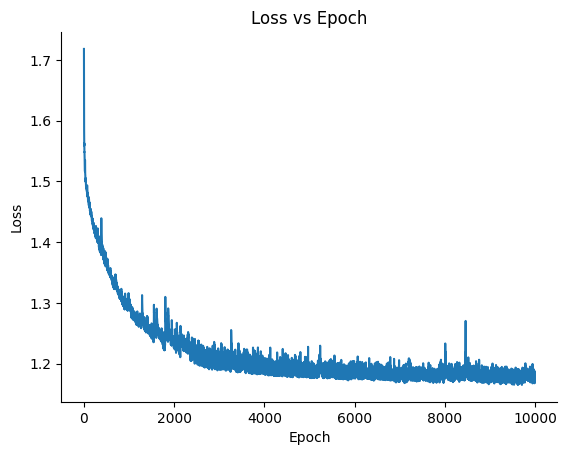

In [354]:
sns.lineplot(x=range(len(losses)), y=losses)
sns.despine()


# Axis labels
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Title
plt.title("Loss vs Epoch")



In [355]:
def test(dataset, model, device="cpu"):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (X, Y) in enumerate(dataset):
            X, Y = X.to(device), Y.to(device)
            X, Y = X.unsqueeze(0), Y.unsqueeze(0)
            pred = model(X).to(device)
            loss = nn.MSELoss()(pred, Y)
            print(f"Loss: {loss.item()}")
            return pred, Y
            

In [356]:
pred, Y = test(dataset, model, device)

Loss: 1.5308829545974731


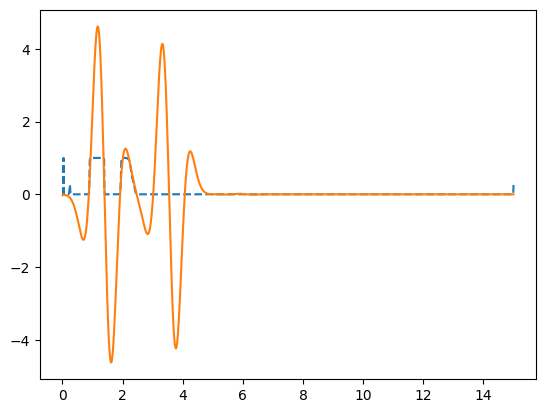

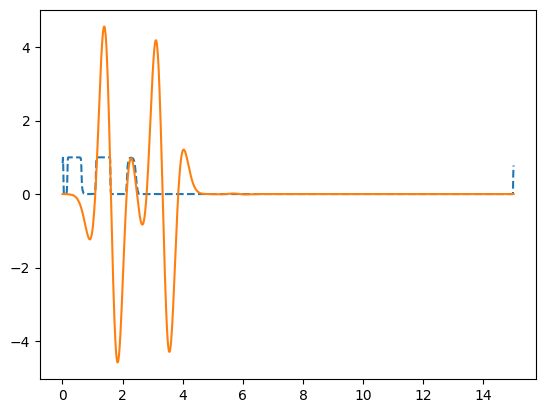

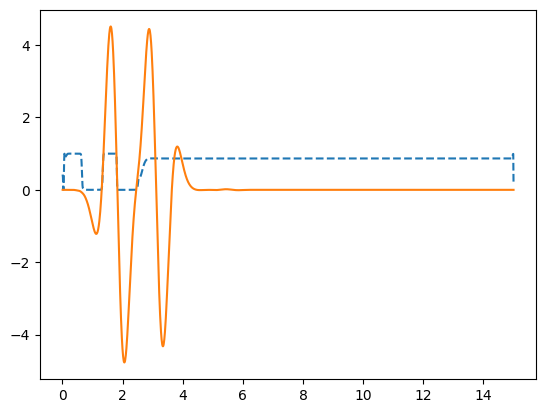

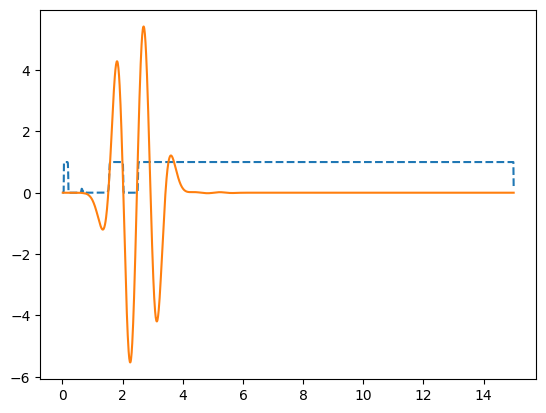

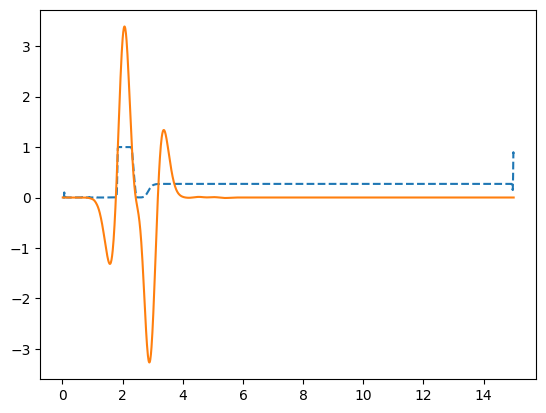

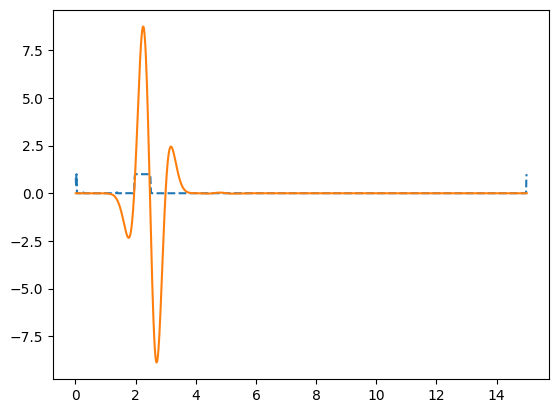

In [357]:
import matplotlib.pyplot as plt

# Plot results
t = time.values

for i in range(6):
    # Start a new figure
    plt.figure()
    sns.lineplot(x=t, y=pred.squeeze(0).squeeze(0)[i].cpu().numpy(), linestyle="--")
    sns.lineplot(x=t, y=Y.squeeze(0).squeeze(0)[i].cpu().numpy())